In [444]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import scipy.optimize as optimize
from copy import deepcopy


# 5-Year YTM Curve
Calculated the yield (YTM) of the selected 10 bonds and plotted a 5-year yield curve (YTM curve) corresponding to each day of data (Jan 10 2023 - Jan 24 2023) superimposed on-top of each other. 

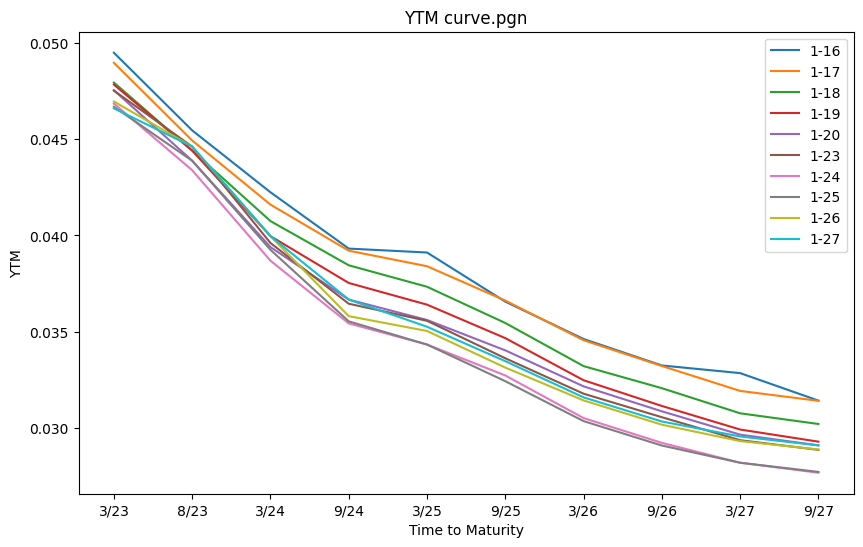

In [451]:
#importing and formating data needed
bond_data = pd.read_excel(r'/Users/susanliu/Desktop/APM466/bonddata.xlsx')

#formating the dates
# bond_data['maturity_date'] = pd.to_datetime(bond_data['Maturity Date'])
bond_data['issue_date'] = pd.to_datetime(bond_data['Issue Date'])
bond_data1 = bond_data.iloc[:, [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]


coupon = [0.0025, 0.0225, 0.015, 0.0125, 0.005, 0.0025, 0.01, 0.0125, 0.0275, 0.035]

Maturity_date = ['2023-08-01', '2024-03-01', '2024-09-01','2025-03-01', '2025-09-01', '2026-03-01', 
                     '2026-09-01', '2027-03-01', '2027-09-01', '2028-03-01']

chosen_date_list = ['2023-01-10', '2023-01-11', '2023-01-12','2023-01-13', '2023-01-16', '2023-01-17', 
                     '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-23', '2023-01-24']
today_date =['2023-02-01']
date_name = ['Jan 10', 'Jan 11', 'Jan 12', 'Jan 13', 'Jan 16', 'Jan 17', 'Jan 18', 'Jan 19', 'Jan 20', 'Jan 23', 'Jan 24']
gap = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

# #setting constants
freq = 2.0
fv = 100.0



#calculating the dates between maturity date and present date
T_lst = []
t = today_date
today_date_t = pd.to_datetime(today_date)
MD = []
for i in range(10):
    MD.append(pd.to_datetime(Maturity_date[i]))
for i in range(10):
    T1 = (MD[i] - today_date_t).days / 365
    T_lst.append(T1)

#calculating the ytm for each bond using the Newton's method
def dytm(notional, T, coup, price, freq=2.0, guess = 0.05, gap_lst = gap):
    coupon = coup * 100/freq 
    t_list = gap_lst[:T+1]
    ytm = lambda y: sum([coupon/(1+y/freq)**(freq*t) for t in t_list]) + notional/(1+y/freq)**(freq*t_list[-1]) - price
    return optimize.newton(ytm, guess)
    

#retrieving ytm for each selected dates:
ytm_dic = {}
for i in range(10):
    price_list = bond_data.iloc[0:10,i+7]
    ytm_dic[chosen_date_list[i]] = []
    for n in range(10):
        cur_ytm = dytm(100, n, coupon[n], price_list[n])
        ytm_dic[chosen_date_list[i]].append(cur_ytm)

#graphing YTM curve
x_axis = ['3/23', '8/23', '3/24', '9/24', '3/25', '9/25', '3/26', '9/26', '3/27', '9/27']
time = ['1-16', '1-17', '1-18', '1-19', '1-20', '1-23', '1-24', '1-25', '1-26', '1-27']
#plotting ytm yield curve 
plt.figure(figsize=(10, 6))
for date in ytm_dic:
    plt.plot(x_axis, ytm_dic[date])
plt.xlabel("Time to Maturity")
plt.ylabel("YTM")
plt.legend(time, loc="upper right", prop={'size': 10})
plt.title("YTM curve.pgn")
plt.savefig('YTM curve.png')



    

# 5-Year Spot Curve
Derived the spot curve with terms ranging from 1-5 years from the chosen bonds. Outputted a 5-year spot curve corresponding to each day of data superimposed on -top of each other

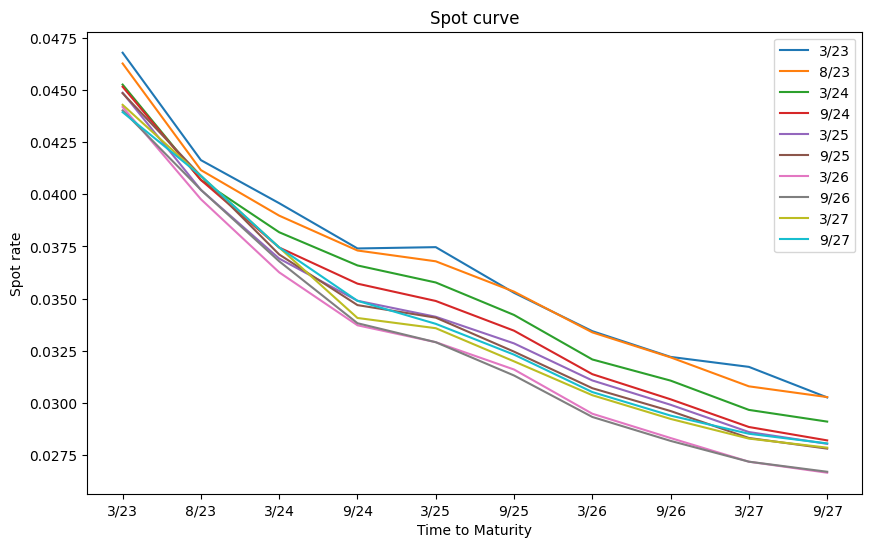

In [457]:

#fining spot rate and generating spot curve
#finding the spot rate for the first T with zero coupon
def spot_rate_zero_coup(price, notional, T, coupon):
    coup = coupon * 100/freq
    return (-np.log(price/notional)/T)

def spot_rate_with_coup(price, T, notional, T_lst, coupon, sp, freq=2):
    coup = coupon * 100/freq
    payment = price
    for i in range(len(sp)):
        payment -= coup * np.exp(-sp[i] * T_lst[i]) 
    return -(np.log(payment / (notional + coup)))/T_lst[T]

notional = 100
spot_dic = {}
for i in range(10):
    price_list = bond_data.iloc[0:10,i+7]
    spot_dic[chosen_date_list[i]] = []
    sr_lst = []
    for n in range(10):
        if T_lst[n] < 0.5: #setting condition, so that the first spot with zero coupon is recorded into the list
            first_spot = spot_rate_zero_coup(price_list[n], notional, T_lst[0], coupon[n])
            spot_dic[chosen_date_list[i]].append(first_spot)
            sr_lst.append(first_spot)
        else:
            spot_r = spot_rate_with_coup(price_list[n], n, notional, T_lst, coupon[n], sr_lst)
            spot_dic[chosen_date_list[i]].append(spot_r)
            sr_lst.append(spot_r)


#graphing the spot rate curve using data added to the spot_dic dictionary
x_axis = ['3/23', '8/23', '3/24', '9/24', '3/25', '9/25', '3/26', '9/26', '3/27', '9/27']
plt.figure(figsize=(10, 6))
plt.xlabel("Time to Maturity")
plt.ylabel("Spot rate")
plt.title("Spot curve")
for date in spot_dic:
    plt.plot(x_axis, spot_dic[date])
plt.legend(x_axis, loc="upper right", prop={'size': 10})
plt.savefig('Spot curve.png')




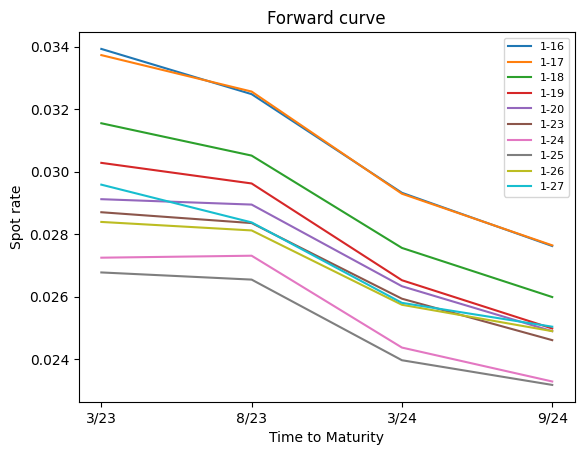

In [456]:

#setting constants
t1 = 1
t2_lst = [2, 3, 4, 5]

#collecting bonds that mature creating a temperary dictionary for the r2 in below's calculation
temp = {}
for i in range(10):
    temp[chosen_date_list[i]] = []
    y2 = spot_dic[chosen_date_list[i]][3]
    y3 = spot_dic[chosen_date_list[i]][5]
    y4 = spot_dic[chosen_date_list[i]][7]
    y5 = spot_dic[chosen_date_list[i]][9]
    temp[chosen_date_list[i]].append(y2)
    temp[chosen_date_list[i]].append(y3)
    temp[chosen_date_list[i]].append(y4)
    temp[chosen_date_list[i]].append(y5)

forward_dic = {}
forward_rate_t1 = []
for i in range(10):
    fr = spot_dic[chosen_date_list[i]][1]
    forward_rate_t1.append(fr)

#calculating forward rate for each bond
for i in range(10):
    price_list = bond_data.iloc[0:10,i+7]
    forward_dic[chosen_date_list[i]] = []
    for n in range(4):
        r2 = temp[chosen_date_list[i]][n]
        t2= t2_lst[n]
        r1 = forward_rate_t1[i-2]
        forward_rate = (r2 * t2 - r1 * 1)/(t2-t1)
        forward_dic[chosen_date_list[i]].append(forward_rate)

#graphing the forward rates into a curve
x_axis = ['3/23', '8/23', '3/24', '9/24']
for date in forward_dic:
    plt.plot(x_axis, forward_dic[date])
plt.xlabel("Time to Maturity")
plt.ylabel("Spot rate")
plt.legend(time, loc="upper right", prop={'size': 8})
plt.title("Forward curve")
plt.savefig('Forward curve.png')


# Covariance Matrices 
Calculated two covariance matrices for the time series of daily log-returns of yield, and the forward rates (no spot rates) 
Calculated the eigenvalues and eigenvectors of both covariance matrices.

In [448]:
#finding yield matrix using the formula given
ytm_matrix = np.zeros([9, 5])
for i in range(5):
    for j in range(9):
        ytm_matrix[j, i] = math.log((ytm_dic[chosen_date_list[j+1]][i*2]) / (ytm_dic[chosen_date_list[j]][i*2]))
ytm_cov_matrix = np.cov(ytm_matrix.T)
ytm_eig_val, ytm_eig_vec = np.linalg.eig(ytm_cov_matrix)
print("yield covariance matrix")
print(ytm_cov_matrix)
print("eigenvector")
print(ytm_eig_vec)
print("eigenvalue")
print(ytm_eig_val)



yield covariance matrix
[[6.35714234e-05 9.33451566e-05 1.07607438e-04 1.40335990e-04
  1.55930134e-04]
 [9.33451566e-05 2.52870524e-04 2.77614108e-04 2.88161872e-04
  3.54045280e-04]
 [1.07607438e-04 2.77614108e-04 3.44507401e-04 3.83095518e-04
  4.43087225e-04]
 [1.40335990e-04 2.88161872e-04 3.83095518e-04 5.38093544e-04
  5.42057949e-04]
 [1.55930134e-04 3.54045280e-04 4.43087225e-04 5.42057949e-04
  6.44686177e-04]]
eigenvector
[[ 0.1540104   0.01903328 -0.35831209  0.91899384 -0.05460134]
 [ 0.35249818 -0.64612005  0.57113299  0.15753163 -0.32751306]
 [ 0.43860915 -0.32804038 -0.70316972 -0.35744561 -0.27892024]
 [ 0.53881683  0.68886837  0.21121035 -0.0479919  -0.43384762]
 [ 0.60772055 -0.00406032  0.0797627  -0.02373865  0.78976809]]
eigenvalue
[1.68994823e-03 8.60654743e-05 8.52435937e-06 2.63616498e-05
 3.28293533e-05]


In [449]:
forward_dic_new = {}
for key in list(forward_dic.keys()):
    lst = []
    for data in forward_dic[key]:
        lst.append(data[0])    
    forward_dic_new[key] = lst

forward_matrix = np.zeros([9, 4])
for i in range(4):
    for j in range(9):
        forward_matrix[j, i] = math.log((forward_dic_new[chosen_date_list[j+1]][i]) / (forward_dic_new[chosen_date_list[j]][i]))
forward_matrix = np.cov(forward_matrix.T)
forward_eig_val, forward_eig_vec = np.linalg.eig(forward_matrix)
print("foward rate covariance matrix")
print(forward_matrix)
print("forward rate eigenvector")
print(forward_eig_vec)
print("forward rate eigenvalue")
print(forward_eig_val)


foward rate covariance matrix
[[0.00174974 0.00136289 0.00150496 0.00149444]
 [0.00136289 0.00120844 0.00132752 0.0013037 ]
 [0.00150496 0.00132752 0.00161601 0.00159313]
 [0.00149444 0.0013037  0.00159313 0.00158758]]
forward rate eigenvector
[[ 0.52300939  0.7708738  -0.35911599 -0.05701294]
 [ 0.4444258   0.11737367  0.87774137  0.13520066]
 [ 0.51688832 -0.44639876 -0.0903737  -0.72483599]
 [ 0.51163792 -0.43898195 -0.30403682  0.67311448]]
forward rate eigenvalue
[5.85714970e-03 2.34733348e-04 6.25609205e-05 7.31673615e-06]
